In [1]:
import torch
import torch.nn          as nn
import numpy             as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch.optim      import Adam

plt.rcParams['figure.dpi'] = 200

In [2]:
# Model Hyperparameters
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

In [4]:
dir = '/STER/silkem/MACE/train_data_C/'

In [7]:
class MyDataset(Dataset):
    def __init__(self, dir, train=True, fraction=0.7):
        
        ## kan hier ook data preprocessing doen
        # ....
        cutoff = 1e-40
        data = []

        for i in range(1,5):
            name = dir+'csfrac_smooth_'+str(i)+'.out'
            clean = MyDataset.read_data(name)
            # print(np.shape(clean))
            data.append(clean)
            
        df = np.concatenate(data)
        df[df < cutoff] = cutoff 
        df = np.log10(df)

        self.df = df.astype(np.float32)
        
        N = int(fraction * self.df.shape[0])
        
        if train:
            # Take fraction of the data
            self.df = self.df[:N]
        else:
            # Take 1-fraction of the data 
            self.df = self.df[N:]
            
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        return self.df[idx]

    @staticmethod
    def read_data(file_name):
        with open(file_name, 'r') as file:
            dirty = []
            clean = None
            for line in file:
                try:  
                    if len(line) > 1: 
                        dirty.append([float(el) for el in line.split()])
                except:
                    if len(dirty) != 0:
                        dirty = np.array(dirty)[:,1:]
                        if clean is None:
                            clean = dirty
                        else:
                            clean = np.concatenate((clean, dirty), axis = 1)
                    dirty = []
        return clean

In [21]:
data = MyDataset(dir)


In [18]:
batch_size = 100
lr = 1e-3
epochs = 30

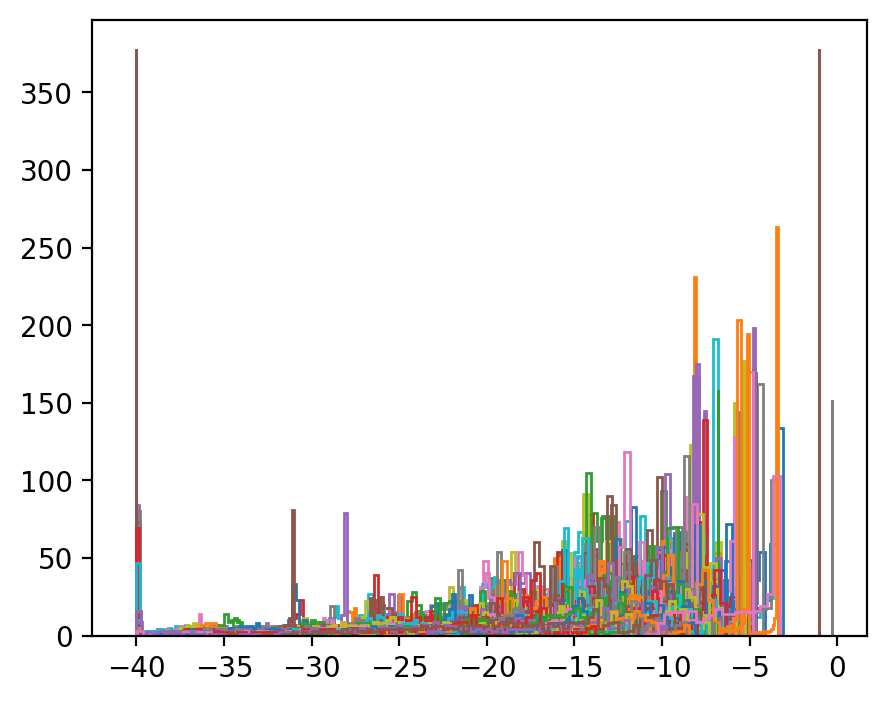

In [ ]:
fig = plt.figure(figsize = (5,4))
ax1 = fig.add_subplot((111))

df = data.df

for i in range(df.shape[1]):
    ax1.hist(df[:,i].ravel(), bins = 100, histtype='step')

plt.show()

In [22]:
kwargs = {'num_workers': 1, 'pin_memory': True} 

data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True,  **kwargs)


In [24]:
class Encoder(nn.Module):
    """
    Encoder network.
    """
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.layer1 = nn.Linear( input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.layer1(x))
        h = self.LeakyReLU(self.layer2(h))
        return h
    
    
class Decoder(nn.Module):
    """
    Decoder network.
    """
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        self.layer1 = nn.Linear(latent_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.layer1(x))
        h = self.LeakyReLU(self.layer2(h))
        return h
    
    
class Autoencoder(nn.Module):
    """
    Autoencoder
    """
    def __init__(self, Encoder, Decoder):
        super(Autoencoder, self).__init__()
        
        self.Encoder = Encoder
        self.Decoder = Decoder
                
    def forward(self, x):
        h = self.Encoder(x)
        h = self.Decoder(h)
        return h

In [ ]:
def loss_function(x, x_hat):
    reproduction_loss = nn.functional.mse_loss(x_hat, x)
    return reproduction_loss

In [ ]:
optimizer = Adam(model.parameters(), lr=lr)


model.train()

for epoch in range(epochs):
    
    overall_loss = 0
    
    for batch_idx, (I, η) in enumerate(train_loader):
        # I = I.view(batch_size, N_freqs)
        # η = η.view(batch_size, N_depth)
        
        I = I.to(DEVICE)
        η = η.to(DEVICE)

        η_hat, mean, log_var = model(I)
        loss                 = loss_function(η, η_hat, mean, log_var)
        # loss                 = loss_function(η, η_hat)
        
        overall_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

	Epoch 1 complete! 	Average Loss:  0.001354424984745672
	Epoch 2 complete! 	Average Loss:  0.0003103168344402567
	Epoch 3 complete! 	Average Loss:  0.00023059129832692454
	Epoch 4 complete! 	Average Loss:  0.00019508747019116138
	Epoch 5 complete! 	Average Loss:  0.0001665187180531823
	Epoch 6 complete! 	Average Loss:  0.00014873623581036682
	Epoch 7 complete! 	Average Loss:  0.00013468247311462523
	Epoch 8 complete! 	Average Loss:  0.00012397465010515144
	Epoch 9 complete! 	Average Loss:  0.00011472355228765997
	Epoch 10 complete! 	Average Loss:  0.00010672861961962583
	Epoch 11 complete! 	Average Loss:  0.00010059591925916295
	Epoch 12 complete! 	Average Loss:  9.548630751902529e-05
	Epoch 13 complete! 	Average Loss:  9.140281919949457e-05
	Epoch 14 complete! 	Average Loss:  8.705841162905227e-05
	Epoch 15 complete! 	Average Loss:  8.379710201192671e-05
	Epoch 16 complete! 	Average Loss:  8.105451408983471e-05
	Epoch 17 complete! 	Average Loss:  7.818223256967468e-05
	Epoch 18 comple